<a href="https://colab.research.google.com/github/brit1172/PomoBuddy/blob/master/TR_Fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***IMU BITTLE DATA PROCESSING AND MODEL TRAINING:***


# Document Details:

Takes in two files: one with data collected from the Teensy 4.0 connected to the two 3-axis imus and the other connected to the second Teensy 4.0 connected solely to the 6-axis imu

Model Specs:
- input: all central 6-axis imu values (x,y,z,roll,yaw,pitch)
- output: two labels that represent whether the front foot is making contact with the ground as well as whether the back foot is making contact
  - used to light up led's on the bittle

Types of models trained:
1. Binary Relevance
2. Multi-Layer Perceptron (MLP)
3. Random Forest or Gradient Boosting
4. k-Nearest Neighbors (kNN) Adaptations
5. Deep Learning Approaches



# Notes

11/14/23: Problem we may have with current code: maps imu x y z from front and back foot to 6-axis imu values -> outputs one single value/class label "contact" or "no contact", what we really want in the output is a class label for each foot I believe
Workflow:
0: implement the seperate contact and no contact labels for each foot
1: Train and fine-tune machine learning model on here (google colab)
2: Once we have a trained model that performs well, export it into a format that can be used on the Arduino. Common formats for deployment on microcontrollers include TensorFlow Lite, ONNX, or custom formats depending on the microcontroller and libraries you plan to use.
3: Deploy the exported model to our Arduino and use it for inference or predictions.

11/16/23:
So far the models that are trained only train on one data session at a time. Next steps would be combining all datasessions into one large set then training all of them on that. Before that, need to collect more sessions because currently the front and back imus have the exact same post-normalization imu values which doesn't make sense.

11/17/23:
Action items are create a function that combines all the data sessions into one datastructure (remove timestamp variable) and convert the 2 labels from one string to two binary. On the hardware side we need to collect more data sessions but not before recalibrating either the imus or teensys (whatever is causing the large difference in magnitude between the two imus), making sure that the resulting normalized values from the front imu are different than that

# **Part 1: Parse data files and fill datastructure**

Part 1.1:
- create function for parsing the data file associated with the Teensy connected to the two 3-axis imus (format is hashmap where keys are timestamps and values are front imu x,y,z then back imu x,y,z)
- note data is normalized before inserted into data structure


In [ ]:
# example of how the data is formatted (sessions 3 and 4 for sure, not sure about 1 and 2)
# 16:59:27.964 -> 290318,f,2.530116,-9.767424,1.627904, b,30.361385,-117.209076,19.534845
# 16:59:28.063 -> 290419,f,2.530116,-9.836070,1.578871, b,30.361385,-118.032845,18.946447
# 16:59:28.161 -> 290521,f,2.549729,-9.718390,1.608291, b,30.596746,-116.620689,19.299488

def normalize_values(values):
    min_val = min(values)
    max_val = max(values)
    return [(x - min_val) / (max_val - min_val) if max_val != min_val else 0 for x in values]

def parse_2_imu(data, fl, filename):
    temp_data = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if '->' not in line:
                continue

            line = line.replace(" ", "")
            sides = line.split('>')

            time_token = sides[0][:10].replace(':', '').replace('.', '')

            imu_tokens = sides[1].split(',')

            if fl:
                front_imu_tokens = [float(imu_tokens[2]), float(imu_tokens[3]), float(imu_tokens[4])]
                back_imu_tokens = [float(imu_tokens[6]), float(imu_tokens[7]), float(imu_tokens[8].replace('\n', ''))]
            else:
                front_imu_tokens = [imu_tokens[2], imu_tokens[3], imu_tokens[4]]
                back_imu_tokens = [imu_tokens[6], imu_tokens[7], imu_tokens[8].replace('\n', '')]

            temp_data.append((time_token, front_imu_tokens + back_imu_tokens))

    # Normalize data
    for i in range(6):  # Assuming 6 values: 3 from front IMU and 3 from back IMU
        axis_values = [entry[1][i] for entry in temp_data]
        normalized_values = normalize_values(axis_values)
        for j, entry in enumerate(temp_data):
            entry[1][i] = normalized_values[j]

    # Add normalized data to the data structure
    for time_token, values in temp_data:
        data[time_token] = values

Part 1.2
- plot x,y,z of 3-axis imus with respect to timestamp to visualize the movement of the robot's left side + determine a method for figuring out when a foot is making contact with the floor and which axis is the axis that is oriented vertically

{'1706158': [0.46843229604264736, 0.2606779025024858, 0.5177398014755914, 0.46843231713675554, 0.26067787592423025, 0.5177398483324344], '1706159': [0.4662921196590285, 0.2606779025024858, 0.5155497119022545, 0.4662921338991479, 0.26067787592423025, 0.515549747551932], '1706160': [0.4657570823830554, 0.2612289819812577, 0.5234340879650172, 0.46575708752141837, 0.2612289905449394, 0.5234341088728864], '1706161': [0.4657570823830554, 0.26012679492461754, 0.5155497119022545, 0.46575708752141837, 0.2601267776946612, 0.515549747551932], '1706162': [0.4668271569350016, 0.2606779025024858, 0.5190538641527186, 0.4668271802768774, 0.26067787592423025, 0.5190539110340171], '1706163': [0.46602458738117875, 0.2606779025024858, 0.5181778372565087, 0.4660246107102831, 0.26067787592423025, 0.518177861788691], '1706164': [0.46655965193687826, 0.2617801176582224, 0.5177398014755914, 0.46655965708801267, 0.2617801402895203, 0.5177398483324344], '1706165': [0.4668271569350016, 0.2609534422418718, 0.51730

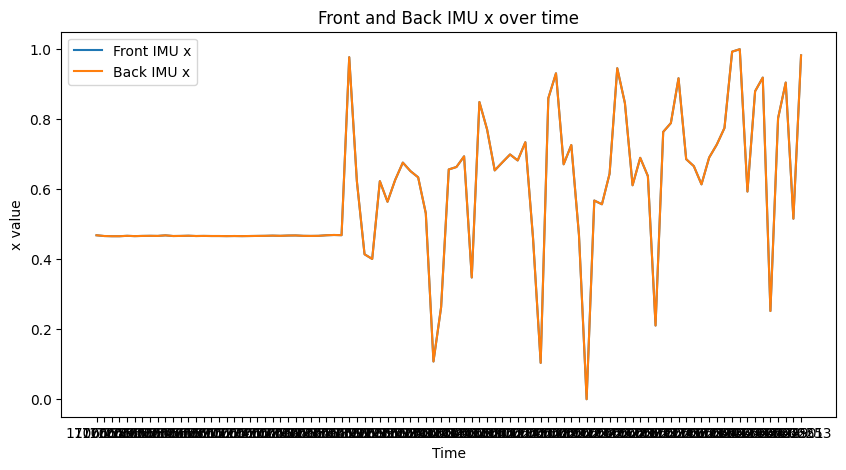

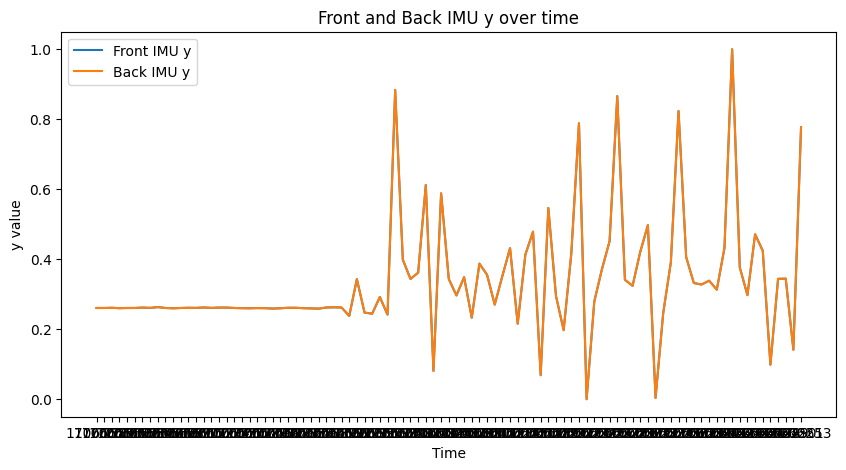

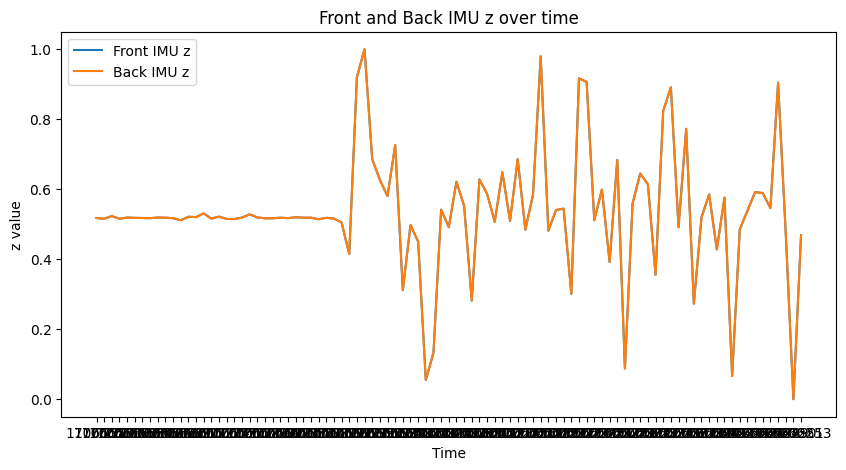

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_imu_data_axis(data, imu_axis):
    """
    Plots both front and back IMU data for a given axis on the same graph.
    imu_axis: 0 for x, 1 for y, 2 for z
    """
    times = sorted(list(data.keys()))
    front_values = [data[time][imu_axis] for time in times]
    back_values = [data[time][imu_axis + 3] for time in times]  # Back IMU values follow the front ones

    plt.figure(figsize=(10, 5))
    plt.plot(times, front_values, label=f"Front IMU {['x', 'y', 'z'][imu_axis]}")
    plt.plot(times, back_values, label=f"Back IMU {['x', 'y', 'z'][imu_axis]}")
    plt.title(f"Front and Back IMU {['x', 'y', 'z'][imu_axis]} over time")
    plt.xlabel("Time")
    plt.ylabel(f"{['x', 'y', 'z'][imu_axis]} value")
    plt.legend()
    plt.show()

def plot_imu_data_axis(data, imu_axis, imu_type):
    """
    imu_axis: 0 for x, 1 for y, 2 for z
    imu_type: 'front' or 'back'
    """
    times = sorted(list(data.keys()))

    if imu_type == 'front':
        values = [data[time][imu_axis] for time in times]
        title = f"Front IMU {['x', 'y', 'z'][imu_axis]} over time"
    else: # 'back'
        values = [data[time][imu_axis + 3] for time in times] # Back IMU values follow the front ones
        title = f"Back IMU {['x', 'y', 'z'][imu_axis]} over time"

    plt.figure(figsize=(10, 5))
    plt.plot(times, values, label=f"{imu_type.capitalize()} IMU {['x', 'y', 'z'][imu_axis]}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(f"{['x', 'y', 'z'][imu_axis]} value")
    plt.legend()
    plt.show()

data = dict()
parse_2_imu(data, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt")
print(data)

# Plot each of the imu axes for front and back
# for axis in range(3):  # x, y, z
#     plot_imu_data_axis(data, axis, 'front')
#     plot_imu_data_axis(data, axis, 'back')

# Plot combined graphs for each axis
for axis in range(3):  # x, y, z
    plot_combined_imu_data_axis(data, axis)

# **Part 2: Determine Contact state of each timestep**

Part 2.1:
- use spikes in y-axis acceleration graphs to determine when contact is happen on a foot or not
- create datastructure with keys being timestamps and values being whether the front foot is making contact with the floor or not, plus the same info about the back foot
- graph generated to fine tune the contact threshold

Vertical axis: y
{'1707082': 'front no contact, back no contact', '1707083': 'front no contact, back no contact', '1707084': 'front no contact, back no contact', '1707085': 'front no contact, back no contact', '1707086': 'front contact, back contact', '1707087': 'front no contact, back no contact', '1707088': 'front contact, back contact', '1707089': 'front contact, back contact', '1707090': 'front contact, back contact', '1707091': 'front contact, back contact', '1707093': 'front no contact, back no contact', '1707094': 'front no contact, back no contact', '1707095': 'front no contact, back no contact', '1707096': 'front contact, back contact', '1707097': 'front contact, back contact', '1707098': 'front contact, back contact', '1707099': 'front contact, back contact', '1707100': 'front no contact, back no contact', '1707101': 'front contact, back contact', '1707102': 'front contact, back contact', '1707103': 'front contact, back contact', '1707104': 'front contact, back contact', '170

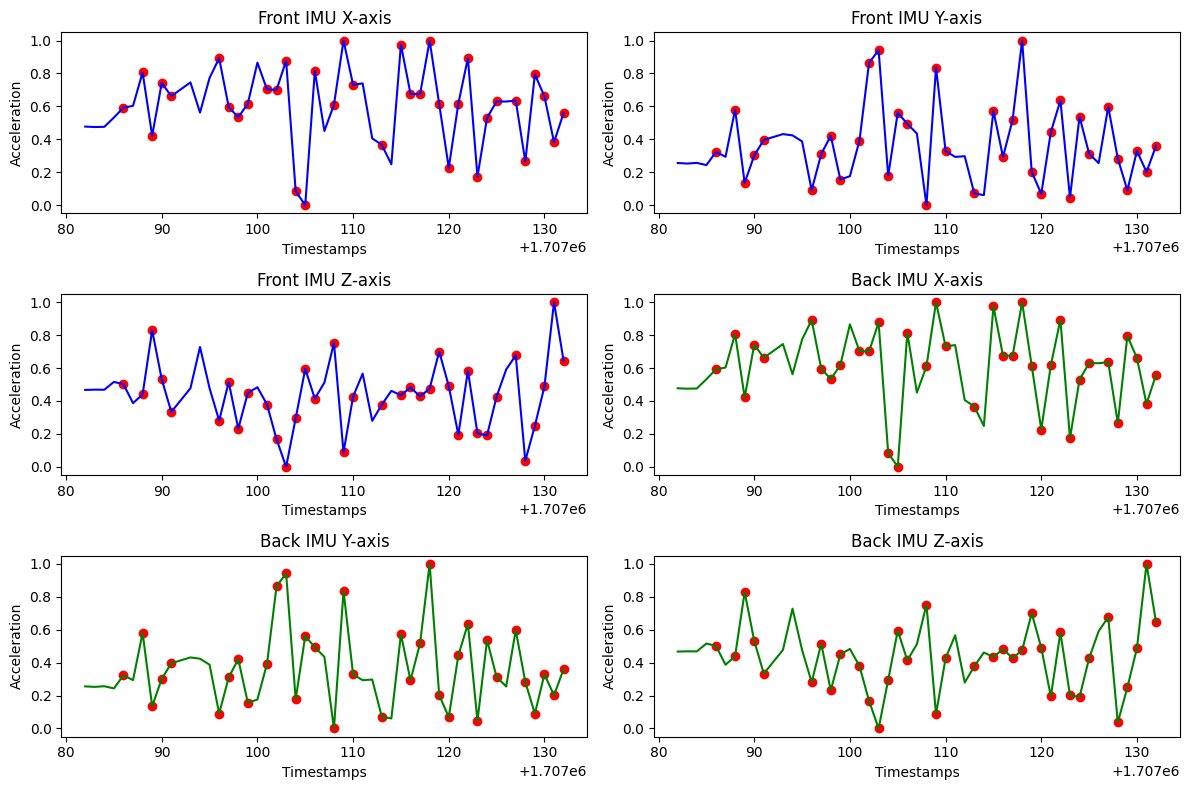

In [ ]:
import matplotlib.pyplot as plt


def detect_contact(data, vertical_axis_index=1, threshold=0.06):
    """
    Detects contact for both front and back feet.
    vertical_axis_index: Index of the vertical axis in the data (default is 1, i.e., y-axis)
    threshold: Threshold for detecting contact (spike in acceleration)
    """
    if vertical_axis_index == 0:
        print("Vertical axis: x")
    elif vertical_axis_index == 1:
        print("Vertical axis: y")
    else:
        print("Vertical axis: z")

    contact_data = {}

    for imu_type in ['front', 'back']:
        imu_offset = 0 if imu_type == 'front' else 3  # Assuming back IMU data starts at index 3
        first_timestamp = next(iter(data))
        prev_value = data[first_timestamp][vertical_axis_index + imu_offset]

        for timestamp, values in data.items():
            # Check for spike (sudden change in acceleration)
            current_value = values[vertical_axis_index + imu_offset]
            if abs(current_value - prev_value) > threshold:
                contact_status = f'{imu_type} contact'
            else:
                contact_status = f'{imu_type} no contact'

            if timestamp in contact_data:
                contact_data[timestamp] += f', {contact_status}'
            else:
                contact_data[timestamp] = contact_status

            prev_value = current_value

    return contact_data


def plot_with_contact(data, contact_data):
    timestamps = [int(t) for t in data.keys()]
    fx, fy, fz, bx, by, bz = zip(*data.values())

    # Plotting for front IMU
    plt.figure(figsize=(12, 8))

    # Helper function to check contact
    def is_contact(timestamp, imu_type):
        return f'{imu_type} contact' in contact_data[str(timestamp)]

    # Plot for each axis and IMU type
    for i, (imu_values, imu_type, color) in enumerate([(fx, 'front', 'b'), (fy, 'front', 'b'), (fz, 'front', 'b'), (bx, 'back', 'g'), (by, 'back', 'g'), (bz, 'back', 'g')]):
        plt.subplot(3, 2, i+1)
        plt.plot(timestamps, imu_values, color + '-', label=f'{imu_type.capitalize()} {["X", "Y", "Z"][i % 3]}')
        plt.scatter([t for t in timestamps if is_contact(t, imu_type)], [imu_values[i] for i, t in enumerate(timestamps) if is_contact(t, imu_type)], c='r', marker='o')
        plt.title(f'{imu_type.capitalize()} IMU {["X", "Y", "Z"][i % 3]}-axis')
        plt.xlabel('Timestamps')
        plt.ylabel('Acceleration')

    plt.tight_layout()
    plt.show()


data = dict()
parse_2_imu(data, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 3/2imu_10.18_2.txt")
contact_results = detect_contact(data)
print(contact_results)
plot_with_contact(data, contact_results)


Part 2.2:
- now that we have, for each timestamp, all six 3-axis imu values plus whether or not these feet are making contact at a given timestamp based on the spikes in the acceleration graphs above we will add in the 6-axis imu x,y,z,roll,pitch,yaw values associated with each timestamp and combined everything into one data structure
- example of one hashmap item: '1706158': [-0.12, -0.79, 0.12, -0.0, -0.1, 1.01, 'front no contact, back no contact']

In [ ]:
# x,y,z,roll,yaw,pitch

def add_6_axis_imu(data, contact_results, fl, filename):
    labeled_data = dict()
    with open(filename, 'r') as file:
        for line in file.readlines():
            if '->' not in line:
                continue  # skips lines that don't follow the format + empty lines

            line = line.replace(" ", "")  # removes spaces
            sides = line.split('>')

            time_token = sides[0][:10].replace(':', '').replace('.', '')
            if time_token not in contact_results:  # if the time_token doesn't have a label, skip it
                continue

            imu_tokens = sides[1].split(',')

            if fl:
                imu_values = [
                    float(imu_tokens[1].split(':')[1]),
                    float(imu_tokens[2].split(':')[1]),
                    float(imu_tokens[3].split(':')[1]),
                    float(imu_tokens[4].split(':')[1]),
                    float(imu_tokens[5].split(':')[1]),
                    float(imu_tokens[6].split(':')[1])
                ]
            else:
                imu_values = [
                    imu_tokens[1].split(':')[1],
                    imu_tokens[2].split(':')[1],
                    imu_tokens[3].split(':')[1],
                    imu_tokens[4].split(':')[1],
                    imu_tokens[5].split(':')[1],
                    imu_tokens[6].split(':')[1]
                ]
            # add the IMU values before the existing contact/no contact label
            labeled_data[time_token] = imu_values + [contact_results[time_token]]
    return labeled_data


data = dict()
parse_2_imu(data, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt")
contact_results = detect_contact(data)
labeled_data = add_6_axis_imu(data, contact_results, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_2.txt")
print(labeled_data)


Vertical axis: y
{'1706158': [-0.12, -0.79, 0.12, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706159': [-0.12, -0.79, 0.12, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706160': [-0.12, -0.73, 0.12, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706161': [-0.12, -0.73, 0.31, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706162': [-0.18, -0.73, 0.0, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706163': [-0.18, -0.67, 0.12, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706164': [-0.18, -0.73, 0.18, -0.01, -0.1, 1.01, 'front no contact, back no contact'], '1706165': [-0.12, -0.73, 0.18, -0.01, -0.1, 1.01, 'front no contact, back no contact'], '1706166': [-0.12, -0.73, -0.06, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706167': [-0.18, -0.67, 0.0, -0.01, -0.1, 1.01, 'front no contact, back no contact'], '1706168': [-0.12, -0.79, -0.06, -0.0, -0.1, 1.01, 'front no contact, back no contact'], '1706169': 

# **Part 3: Combine all data sessions into one data structure and make labels binary**

# **Part 4: Pass in inputs (six 6-axis imu values) and outputs ("contact" vs "no contact" classes) into a model and train**

# !!Note: Make sure all the previous code blocks have been run in order before running any of the blocks below!!

Model Training Outline:
1. Prepare the data
2. Split the data into training and testing sets.
3. Train a classifier on the training set.
4. Test the classifier on the testing set.

*Note that since each data point is associated with two labels, this is a Multi-label Classification problem

# 4.1 Binary Relevance
"Given the simplicity of your output labels (binary for both front and back foot contact), the Binary Relevance method could be a straightforward and effective approach. It treats each label (front foot contact, back foot contact) as a separate binary classification problem. You can use standard classifiers like Random Forest, Support Vector Machines, or Gradient Boosting for each label."

In [ ]:
pip install numpy pandas scikit-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def binary_relevance(three_axis_file, six_axis_file):

    data = dict()
    parse_2_imu(data, True, three_axis_file)
    contact_results = detect_contact(data)
    labeled_data = add_6_axis_imu(data, contact_results, True, six_axis_file)
    binary_labeled_data = list()

    for key in labeled_data:
        entry = [key] + labeled_data[key]
        #print(entry)
        contact_label = entry[7]
        front = contact_label.split(',')[0]
        back = contact_label.split(',')[1]
        if front == 'front no contact':
            entry[7] = False
        else:
            entry[7] = True

        if back == ' back no contact':
            entry.append(False)
        else:
            entry.append(True)

        binary_labeled_data.append(entry)

    # binary_labeled_data is our dataset in the format: [timestamp, x, y, z, roll, yaw, pitch, front_contact, back_contact] where front_contact and back_contact are booleans

    # Load data into a DataFrame
    # Replace 'data' with the actual source of your data
    df = pd.DataFrame(binary_labeled_data, columns=['timestamp', 'x', 'y', 'z', 'roll', 'yaw', 'pitch', 'front_contact', 'back_contact'])

    # Drop the timestamp as it's likely not useful for prediction
    df = df.drop(columns=['timestamp'])

    # Separate features and labels
    X = df[['x', 'y', 'z', 'roll', 'yaw', 'pitch']]
    y = df[['front_contact', 'back_contact']]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Training two separate Random Forest classifiers: one for each label
    classifiers = {
        'front_contact': RandomForestClassifier(random_state=42),
        'back_contact': RandomForestClassifier(random_state=42)
    }

    # Train each classifier and make predictions
    for label, clf in classifiers.items():
        clf.fit(X_train, y_train[label])
        y_pred = clf.predict(X_test)
        print(f"Accuracy for {label}: {accuracy_score(y_test[label], y_pred)}")

    # Example of making predictions with the trained models
    def make_prediction(input_data):
        scaled_data = scaler.transform([input_data])
        predictions = {label: clf.predict(scaled_data)[0] for label, clf in classifiers.items()}
        return predictions

    # Example usage
    example_input = [-0.12, -0.79, 0.12, -0.0, -0.1, 1.010]  # Replace with real IMU data
    print("Predictions:", make_prediction(example_input))

three_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt"
six_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_2.txt"
binary_relevance(three_axis_file, six_axis_file)


Vertical axis: y
Accuracy for front_contact: 0.7222222222222222
Accuracy for back_contact: 0.7222222222222222
Predictions: {'front_contact': False, 'back_contact': False}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Results per trial as of 11/16/23:

10.19_2:
- Accuracy for front_contact: 0.7222222222222222
- Accuracy for back_contact: 0.7222222222222222



# 4.2 Multi-Layer Perceptron (MLP)
"A Multi-Layer Perceptron, a type of neural network, can be configured to output two nodes in the final layer, each corresponding to one of your labels (front foot and back foot contact). MLPs are flexible and capable of capturing complex relationships in your data, especially if there are nonlinear patterns."

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def multi_layer_perceptron(three_axis_file, six_axis_file):

    data = dict()
    parse_2_imu(data, True, three_axis_file)
    contact_results = detect_contact(data)
    labeled_data = add_6_axis_imu(data, contact_results, True, six_axis_file)
    binary_labeled_data = list()

    for key in labeled_data:
        entry = [key] + labeled_data[key]
        #print(entry)
        contact_label = entry[7]
        front = contact_label.split(',')[0]
        back = contact_label.split(',')[1]
        if front == 'front no contact':
            entry[7] = False
        else:
            entry[7] = True

        if back == ' back no contact':
            entry.append(False)
        else:
            entry.append(True)

        binary_labeled_data.append(entry)

    # Assuming 'binary_labeled_data' format:
    # [timestamp, x, y, z, roll, yaw, pitch, front_contact, back_contact]

    # Load data into a DataFrame
    df = pd.DataFrame(binary_labeled_data, columns=['timestamp', 'x', 'y', 'z', 'roll', 'yaw', 'pitch', 'front_contact', 'back_contact'])

    # Drop the timestamp as it's likely not useful for prediction
    df = df.drop(columns=['timestamp'])

    # Separate features and labels
    X = df[['x', 'y', 'z', 'roll', 'yaw', 'pitch']]
    y = df[['front_contact', 'back_contact']]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Training an MLP Classifier
    mlp = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=300, activation='relu', solver='adam', random_state=42)
    mlp.fit(X_train, y_train)

    # Prediction and Evaluation
    y_pred = mlp.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Example of making predictions with the trained model
    def make_prediction(input_data):
        scaled_data = scaler.transform([input_data])
        prediction = mlp.predict(scaled_data)
        return {'front_contact': prediction[0, 0], 'back_contact': prediction[0, 1]}

    # Example usage
    example_input = [-0.12, -0.79, 0.12, -0.0, -0.1, 1.010]  # Replace with real IMU data
    print("Predictions:", make_prediction(example_input))


three_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt"
six_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_2.txt"
multi_layer_perceptron(three_axis_file, six_axis_file)


Vertical axis: y
Accuracy: 0.7222222222222222
Predictions: {'front_contact': 0, 'back_contact': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 4.3 Random Forest and Gradient Boosting
"These ensemble methods can also be adapted for multi-label classification. They are robust, handle a mix of different types of input features well, and can capture complex relationships in the data."

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def rf_or_gb(three_axis_file, six_axis_file, random_forest):

    data = dict()
    parse_2_imu(data, True, three_axis_file)
    contact_results = detect_contact(data)
    labeled_data = add_6_axis_imu(data, contact_results, True, six_axis_file)
    binary_labeled_data = list()

    for key in labeled_data:
        entry = [key] + labeled_data[key]
        #print(entry)
        contact_label = entry[7]
        front = contact_label.split(',')[0]
        back = contact_label.split(',')[1]
        if front == 'front no contact':
            entry[7] = False
        else:
            entry[7] = True

        if back == ' back no contact':
            entry.append(False)
        else:
            entry.append(True)

        binary_labeled_data.append(entry)

    # Load data into a DataFrame
    df = pd.DataFrame(binary_labeled_data, columns=['timestamp', 'x', 'y', 'z', 'roll', 'yaw', 'pitch', 'front_contact', 'back_contact'])

    # Drop the timestamp
    df = df.drop(columns=['timestamp'])

    # Separate features and labels
    X = df[['x', 'y', 'z', 'roll', 'yaw', 'pitch']]
    y = df[['front_contact', 'back_contact']]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if random_forest:
        # Using Random Forest Classifier for each label
        print("Random Forest")
        classifiers = {
            'front_contact': RandomForestClassifier(random_state=42),
            'back_contact': RandomForestClassifier(random_state=42)
        }
    else:
        # Using Gradient Boosting Classifier for each label
        print("Gradient Boosting")
        classifiers = {
            'front_contact': GradientBoostingClassifier(random_state=42),
            'back_contact': GradientBoostingClassifier(random_state=42)
        }

    # Train and evaluate each classifier
    for label, clf in classifiers.items():
        clf.fit(X_train, y_train[label])
        y_pred = clf.predict(X_test)
        print(f"Accuracy for {label}: {accuracy_score(y_test[label], y_pred)}")

three_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt"
six_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_2.txt"
rf_or_gb(three_axis_file, six_axis_file, True)
rf_or_gb(three_axis_file, six_axis_file, False)



Vertical axis: y
Random Forest
Accuracy for front_contact: 0.7222222222222222
Accuracy for back_contact: 0.7222222222222222
Vertical axis: y
Gradient Boosting
Accuracy for front_contact: 0.7222222222222222
Accuracy for back_contact: 0.7222222222222222


# 4.4 k-Nearest Neighbors (kNN) Adaptations
"ML-kNN is a simple adaptation of the kNN algorithm for multi-label classification. It can work well if your dataset is not too large and if similar measurement patterns correspond to similar contact patterns for the feet."


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def kNN(three_axis_file, six_axis_file):

    data = dict()
    parse_2_imu(data, True, three_axis_file)
    contact_results = detect_contact(data)
    labeled_data = add_6_axis_imu(data, contact_results, True, six_axis_file)
    binary_labeled_data = list()

    for key in labeled_data:
        entry = [key] + labeled_data[key]
        #print(entry)
        contact_label = entry[7]
        front = contact_label.split(',')[0]
        back = contact_label.split(',')[1]
        if front == 'front no contact':
            entry[7] = False
        else:
            entry[7] = True

        if back == ' back no contact':
            entry.append(False)
        else:
            entry.append(True)

        binary_labeled_data.append(entry)

    # Load data into a DataFrame
    df = pd.DataFrame(binary_labeled_data, columns=['timestamp', 'x', 'y', 'z', 'roll', 'yaw', 'pitch', 'front_contact', 'back_contact'])

    # Drop the timestamp
    df = df.drop(columns=['timestamp'])

    # Separate features and labels
    X = df[['x', 'y', 'z', 'roll', 'yaw', 'pitch']]
    y = df[['front_contact', 'back_contact']]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Using kNN Classifier for each label
    classifiers = {
        'front_contact': KNeighborsClassifier(),
        'back_contact': KNeighborsClassifier()
    }

    # Train and evaluate each classifier
    for label, clf in classifiers.items():
        clf.fit(X_train, y_train[label])
        y_pred = clf.predict(X_test)
        print(f"Accuracy for {label}: {accuracy_score(y_test[label], y_pred)}")


three_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_2.txt"
six_axis_file =  "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_2.txt"
kNN(three_axis_file, six_axis_file)


Vertical axis: y
Accuracy for front_contact: 0.6111111111111112
Accuracy for back_contact: 0.6111111111111112


# 4.5 Deep Learning Approaches
"If your dataset is large and complex, deep learning models like Convolutional Neural Networks (CNNs) or simple feed-forward networks can be applied. They can automatically capture intricate patterns in the data, but require a sufficient amount of data to train effectively."

In [ ]:
pip install tensorflow

# Part 5: Other Misc. Model Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'labeled_data' dict includes two labels now

# Convert to DataFrame
df = pd.DataFrame.from_dict(labeled_data, orient='index', columns=['roll', 'yaw', 'pitch', 'x', 'y', 'z', 'label1', 'label2'])

# Separate features and labels
X = df.drop(columns=['label1', 'label2'])
y = df[['label1', 'label2']]  # Multi-label

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
clf = RandomForestClassifier()  # Note: RandomForestClassifier might not be the best choice for multi-label tasks
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Evaluation
# You'll need a more complex metric for multi-label classification
print("Accuracy:", accuracy_score(y_test, y_pred))


# Trial 10.18_2:
# Accuracy Score: 0.9

# Trial 10.19_1:
# Accuracy Score: 0.964


0.9642857142857143


"Note:

This is a very basic example. In practice, you'd probably want to perform data normalization, hyperparameter tuning, and possibly feature engineering.
The way the classes were determined in the previous answer is very naive and might not be accurate for real-world scenarios. If possible, consider collecting labeled data or implementing more sophisticated methods for ground truth generation.
Neural Networks or LSTM models might be particularly beneficial here since they can capture temporal relationships, which could be vital when dealing with IMU data over time."

Try Gradient Boosting: "Gradient Boosting is a powerful ensemble learning method that builds a sequence of decision trees, where each subsequent tree corrects the mistakes of the previous one."

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# using 'labeled_data' dict as data

# Convert to DataFrame
df = pd.DataFrame.from_dict(labeled_data, orient='index', columns=['roll', 'yaw', 'pitch', 'x', 'y', 'z', 'label'])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Evaluation
print(accuracy_score(y_test, y_pred))

# Trial 10.18_2:
# Accuracy Score: 0.6

# Trial 10.19_1:
# Accuracy Score: 1.0

1.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# HYPERTUNING PARAMETERS FOR GRADIENT BOOSTING
# "Cross-validation is a technique to get a more reliable estimate of the model performance by splitting the training data multiple times and calculating the average performance."

# Separate features and labels, train-test split and scaling as before

# Grid Search setup
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

clf = GradientBoostingClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)  # cv=5 means 5-fold cross validation, n_jobs=-1 uses all processors for parallel processing

grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Prediction
y_pred = best_classifier.predict(X_test)

# Evaluation
print(accuracy_score(y_test, y_pred))


# Trial 10.18_2:
# Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': None, 'n_estimators': 50, 'subsample': 1.0}
# Accuracy Score: 0.6

# Trial 10.19_1:
# Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 1.0}
# Accuracy Score: 0.9642857142857143


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 1.0}
0.9642857142857143


Step 4: Train a Neural Network

4.1: Setup and Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

data = dict()
parse_2_imu(data, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_1.txt")
contact_results = detect_contact(data)
labeled_data = add_6_axis_imu(data, contact_results, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_1.txt")
# using 'labeled_data' dict as data input for NN

# Convert to DataFrame
df = pd.DataFrame.from_dict(labeled_data, orient='index', columns=['roll', 'yaw', 'pitch', 'x', 'y', 'z', 'label'])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Encode the labels: 'no contact' -> 0 and 'contact' -> 1
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


vertical axis: y


4.2: Building and Training NN

In [ ]:
# Model setup
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store its history for graphing
history = model.fit(X_train, y_train, epochs=200, batch_size=4, validation_split=0.2)  # using 20% of training data as validation


Epoch 1/200
22/22 [==============================] - 1s 11ms/step - loss: 0.6119 - accuracy: 0.7011 - val_loss: 0.5273 - val_accuracy: 0.7273
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 0.4348 - accuracy: 0.8046 - val_loss: 0.4540 - val_accuracy: 0.7273
Epoch 3/200
22/22 [==============================] - 0s 4ms/step - loss: 0.3443 - accuracy: 0.8046 - val_loss: 0.4036 - val_accuracy: 0.7273
Epoch 4/200
22/22 [==============================] - 0s 4ms/step - loss: 0.2918 - accuracy: 0.8046 - val_loss: 0.3663 - val_accuracy: 0.7273
Epoch 5/200
22/22 [==============================] - 0s 4ms/step - loss: 0.2586 - accuracy: 0.8046 - val_loss: 0.3383 - val_accuracy: 0.7273
Epoch 6/200
22/22 [==============================] - 0s 5ms/step - loss: 0.2358 - accuracy: 0.8046 - val_loss: 0.3133 - val_accuracy: 0.7273
Epoch 7/200
22/22 [==============================] - 0s 5ms/step - loss: 0.2181 - accuracy: 0.8276 - val_loss: 0.2926 - val_accuracy: 0.9545
Epoch 8/200


4.3: Evaluation

In [ ]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


# 10.19_1:
# 1/1 [==============================] - 0s 29ms/step - loss: 0.1115 - accuracy: 0.9643
# Test Accuracy: 96.43%


1/1 [==============================] - 0s 28ms/step - loss: 0.1278 - accuracy: 0.9643
Test Accuracy: 96.43%


4.4: For each new batch of data coming in we want to update the model:

In [ ]:
def train_on_new_data(X_new, y_new, model, scaler, epochs=50):
    """
    Updates the model with new data.

    Parameters:
    - X_new: New feature data.
    - y_new: New labels.
    - model: The neural network model.
    - scaler: The scaler used during initial training.
    - epochs: Number of training iterations (default is 5).
    """

    # Scale the new data using the same scaler
    X_new = scaler.transform(X_new)

    # Update the model
    return model.fit(X_new, y_new, epochs=epochs)

def append_history(history1, history2):
    """
    Appends history2 to history1

    Parameters:
    - history1: The first training history.
    - history2: The second training history to be appended.

    Returns:
    - Combined history.
    """

    # Initialize a combined history if history1 is None
    if history1 is None:
        return history2

    # Append each metric from history2 to history1
    for key in history2.history:
        history1.history[key].extend(history2.history[key])

    return history1


data = dict()
parse_2_imu(data, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/2imu_10.19_3.txt")
contact_results = detect_contact(data)
labeled_data = add_6_axis_imu(data, contact_results, True, "/content/drive/Shareddrives/A2R Lab/Tiny Robots/Fall 2023/Data Collection and Processing/Data/Session 4/6imu_10.19_3.txt")
# using 'labeled_data' dict as data input for NN

# Convert to DataFrame
new_data = pd.DataFrame.from_dict(labeled_data, orient='index', columns=['roll', 'yaw', 'pitch', 'x', 'y', 'z', 'label'])

# Let's say you have new_data (a DataFrame with features and labels) coming in:
X_new = new_data.drop(columns=['label'])
y_new = encoder.transform(new_data['label'])  # Assuming encoder is the same LabelEncoder from before

history2 = train_on_new_data(X_new, y_new, model, scaler)
history = append_history(history, history2)

# Optionally save the model if you want to use it later:
# model.save('updated_model.h5')


1712447
no contact
1712448
no contact
1712449
contact
1712450
contact
1712451
contact
1712452
contact
1712453
contact
1712455
contact
1712456
contact
1712457
contact
1712457
contact
1712458
no contact
1712459
contact
1712460
contact
1712461
contact
1712463
contact
1712464
contact
1712465
contact
1712466
contact
1712467
contact
1712468
contact
1712469
contact
1712470
contact
1712471
no contact
1712472
contact
1712474
contact
1712475
contact
1712476
contact
1712477
contact
1712478
no contact
1712479
contact
1712480
contact
1712481
contact
1712482
contact
1712483
contact
1712484
contact
1712486
contact
1712487
contact
1712488
contact
1712489
contact
1712490
contact
1712491
contact
1712492
contact
1712493
contact
1712494
no contact
1712495
contact
1712497
contact
1712498
no contact
1712499
contact
1712500
contact
1712501
no contact
1712502
contact
1712503
contact
1712503
contact
1712504
contact
1712506
contact
1712507
contact
1712508
contact
1712509
contact
1712510
contact
1712511
contact


4.5: Graph the training

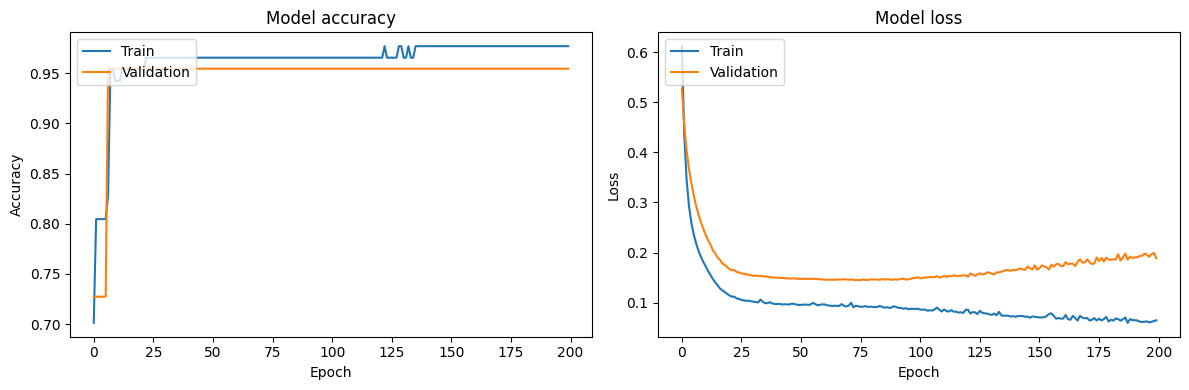

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



**USING TRAINED NN TO PREDICT IF FOOT IS DOWN GIVEN 6-AXIS:**

In [ ]:
def predict_contact(data_point, trained_model, scaler, threshold=0.5):
    """
    Predicts whether there is contact or no contact based on the input data_point.

    Parameters:
    - data_point: The input 6-axis IMU data as a list or numpy array.
    - trained_model: The trained neural network model.
    - scaler: The scaler used during training.
    - threshold: The threshold for classifying the output (default is 0.5).

    Returns:
    - String: "contact" or "no contact".
    """

    # Reshape the data_point to have the shape (num_samples, num_features)
    data_point = np.array(data_point).reshape(1, -1)

    # Scale the data_point
    scaled_data = scaler.transform(data_point)

    # Make the prediction
    prediction = trained_model.predict(scaled_data)

    # Threshold the prediction
    if prediction >= threshold:
        return "contact"
    else:
        return "no contact"


incoming_data = [-0.12, -0.79, -0.06, -0.0, -0.1, 1.01]  # replace with real-time data
result = predict_contact(incoming_data, model, scaler)
print(result)  # This will print "contact" or "no contact" based on the model's prediction.


1/1 [==============================] - 0s 38ms/step
contact


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Convert the trained model to TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#save model to disk
open("binary_conctact.tflite", "wb").write(tflite_model)
import os
model_size = os.path.getsize("binary_conctact.tflite")
print('Size of the model is %d bytes' % model_size)


In [ ]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i binary_contact.tflite > binary_contact_model.cc #should create a header and cpp file of the model, download from the left-side menu in colab
# Print the source file
!cat binary_contact_model.cc